<!-- Add CSS Styles. Content starts in the next cell. -->

<!-- Boxes that stand out to catch the readers attention. -->

<style>
.info {
  padding: 20px;
  background-color: #139ed6;
  color: white;
  margin-bottom: 15px;
}

.info:before {
 content: "📝";
}

.warn {
  padding: 20px;
  background-color: #d11414;
  color: white;
  margin-bottom: 15px;
}

.warn:before {
 content: "⚠️";
}
</style>

# Predicting Future Sales

This notebook contains the process of the data for my submission
to the Kaggle competition ["Predicting Future Sales"](https://www.kaggle.com/c/competitive-data-science-predict-future-sales).

A setup guide for the runtime environment can be found in the projects
[README](./README.adoc) file.

<!-- Table of contents -->

<!-- TODO: add TOC -->

## Prerequisites

### Imports

In [1]:
# Basic packages
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Advanced features
from itertools import product
from datetime import datetime

# Machine learning tools
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

# My packages
import src.plotting.Defaults
from src.datacleaning.ConvertingDateValues import date_to_month, date_to_iso8601, iso8601_format
from src.util.FunctionExecTime import time_runtime

### Set package options

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

%matplotlib inline
# set the default marker style for all plots
src.plotting.Defaults.set_defaults()

### Import data

In [3]:
# Metadata packages
items = pd.read_csv('data/info/items.csv')
shops = pd.read_csv('data/info/shops.csv')
cats = pd.read_csv('data/info/item_categories.csv')

# Train and test data
train = pd.read_csv('data/technical/sales_train.csv', parse_dates=['date'])
test  = pd.read_csv('data/technical/test.csv').set_index('ID')

### Data formatting

In [4]:
# contains the raw train with months only
trains_in_months = train.copy()
train_in_months = time_runtime(date_to_month, trains_in_months)

Runtime: 13s


## Exploratory Data Analysis


### View monthly sales

In [5]:
def view_all_sales():
    # create a new data frame with the relevant columns.
    df = pd.DataFrame(train_in_months, columns=['date', 'item_cnt_day'])
    df.set_index('date', inplace=True)

    # sum the values to get a monthly overview
    df = df.groupby(['date']).sum()

    # rename the column to match new output
    df.rename(columns = {'item_cnt_day':'item_cnt_month'}, inplace = True)

    return df

all_sales = time_runtime(view_all_sales)

Runtime: 240ms


<AxesSubplot:xlabel='date'>

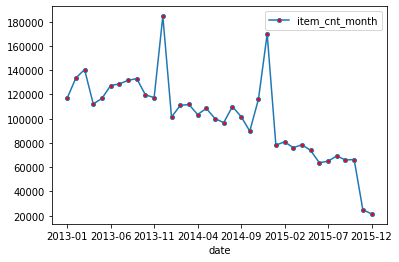

In [6]:
all_sales.plot()

<div class="info">
    We can observe a strong seasonality with spiking end of year sales.
    <br>
    This is particularily noteworthy as the month to predict in question is
    going to be the month of november.
    <br><br>
    Additionally, the trend seems to be going downwards over time.
</div>

### View monthly revenue

In [7]:
def compute_revenue():
    # pick the relevant columns
    df = pd.DataFrame(train_in_months, columns=['date', 'item_cnt_day', 'item_price'])
    # calculate the revenue
    df['revenue'] = df.apply(lambda x: x['item_cnt_day'] * x['item_price'], axis=1)
    # drop no longer needed columns
    df.drop(['item_cnt_day', 'item_price'], axis=1, inplace=True)

    # set the index
    df.set_index('date', inplace=True)
    # and regroup the monthly revenue
    return df.groupby(['date']).sum()

revenue = time_runtime(compute_revenue)

Runtime: 19s


<AxesSubplot:xlabel='date'>

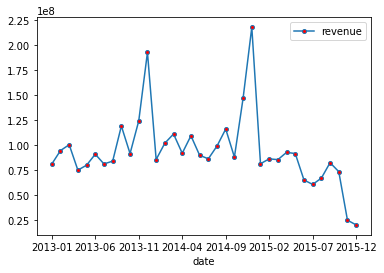

In [8]:
revenue.plot()

<div class="info">
    Fortunately, the revenue is closely correlated to the total sales as
    excpected.
</div>

### Inspect `item_cnt_day`

<AxesSubplot:xlabel='item_cnt_day'>

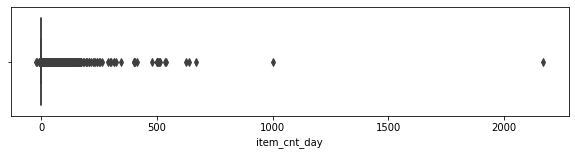

In [9]:
plt.figure(figsize=(10,2))
sns.boxplot(x=train_in_months.item_cnt_day)

<div class="info">
    Two outliers can be observed. This will have to be examined further
    down the line.
</div>

### Inspect `item_price`

<AxesSubplot:xlabel='item_price'>

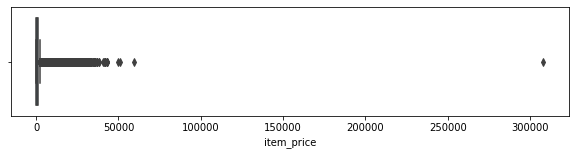

In [10]:
plt.figure(figsize=(10,2))
sns.boxplot(x=train_in_months.item_price)

<div class="info">
    One outlier can be observed. This will have to be examined further
    down the line.
</div>

### Inspect `item_id`

In [11]:
def inspect_total_sales_per_item_cat():
    df = pd.DataFrame(train_in_months, columns=['item_cnt_day', 'item_id'])
    df = df.set_index('item_id', drop=True).join(items.set_index('item_id'))
    df.drop(['item_name'], axis=1, inplace=True)
    df.set_index(['item_category_id'], inplace=True)
    df = df.groupby(['item_category_id']).sum()
    df.rename(columns = {'item_cnt_day':'item_cnt_total'}, inplace = True)

    return df


sales_per_item_cat = time_runtime(inspect_total_sales_per_item_cat)

Runtime: 396ms


Text(0, 0.5, 'Total item category sales')

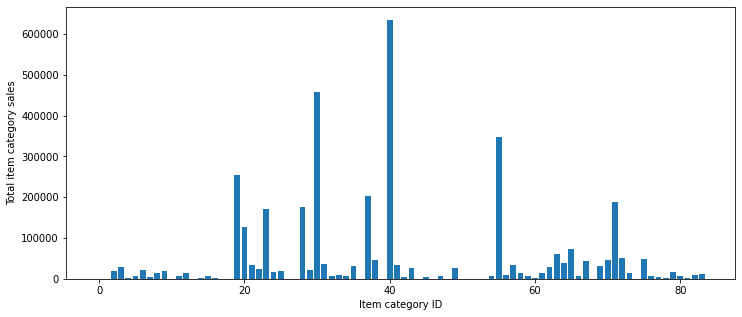

In [12]:
plt.figure(figsize=(12,5))
plt.bar(sales_per_item_cat.index, sales_per_item_cat['item_cnt_total'])
plt.xlabel("Item category ID")
plt.ylabel("Total item category sales")

#### Inspect outliers

Obvious top-performers are found. Let's find out what the category corresponds
to as well as verify that there are no categories without any sale records.

In [13]:
top_performing_item_categories = sales_per_item_cat[sales_per_item_cat['item_cnt_total'] > 200_000]
top_performing_item_categories = top_performing_item_categories.join(cats, on='item_category_id', how='inner')
top_performing_item_categories.head(top_performing_item_categories.size)

,item_cnt_total,item_category_name,item_category_id
item_category_id,,,
19,254887.0,Игры - PS3,19
30,456540.0,Игры PC - Стандартные издания,30
37,203284.0,Кино - Blu-Ray,37
40,634171.0,Кино - DVD,40
55,348591.0,Музыка - CD локального производства,55


Let's have a look at the translation ([using Google Translate](https://translate.google.com/?sl=ru&tl=en&op=translate))

| Russian                               | Translation                           |
| ------------------------------------- | ------------------------------------- |
| Игры - PS3                            | Games - PS3                           |
| Игры PC - Стандартные издания	        | PC Games - Standard Editions          |
| Кино - Blu-Ray	                    | Movie - Blu-Ray                       |
| Кино - DVD	                        | Movies - DVD                          |
| Музыка - CD локального производства   | Music - locally produced CD           |

In [14]:
low_performing_item_categories = sales_per_item_cat[sales_per_item_cat['item_cnt_total'] < 10]
low_performing_item_categories = low_performing_item_categories.join(cats, on='item_category_id', how='inner')
low_performing_item_categories.head(low_performing_item_categories.size)

,item_cnt_total,item_category_name,item_category_id
item_category_id,,,
0,3.0,PC - Гарнитуры/Наушники,0
1,2.0,Аксессуары - PS2,1
10,1.0,Игровые консоли - PS2,10
27,8.0,Игры MAC - Цифра,27
48,6.0,Книги - Компьютерная литература,48
50,3.0,Книги - Открытки,50
51,1.0,Книги - Познавательная литература,51
52,3.0,Книги - Путеводители,52
53,3.0,Книги - Художественная литература,53


Let's have a look at the translation ([using Google Translate](https://translate.google.com/?sl=ru&tl=en&op=translate))

| Russian                               | Translation                           |
| ------------------------------------- | ------------------------------------- |
| PC - Гарнитуры/Наушники	            | PC - Headsets / Headphones            |
| Аксессуары - PS2	                    | Accessories - PS2                     |
| Игровые консоли - PS2	                | Game consoles - PS2                   |
| Игры MAC - Цифра	                    | MAC Games - Number                    |
| Книги - Компьютерная литература	    | Books - Computer Literature           |
| Книги - Открытки	                    | Books - Postcards                     |
| Книги - Познавательная литература     | Books - Educational literature        |
| Книги - Путеводители                  | Books - Guides                        |
| Книги - Художественная литература     | Books - Fiction                       |

Books seem to be in very low demand. Let's find out if there are any other
categories containing books.

In [15]:
other_book_cats = cats[cats['item_category_name'].str.contains("Книги")]
other_book_cats.head(other_book_cats.size)

,item_category_name,item_category_id
42,"Книги - Артбуки, энциклопедии",42
43,Книги - Аудиокниги,43
44,Книги - Аудиокниги (Цифра),44
45,Книги - Аудиокниги 1С,45
46,Книги - Бизнес литература,46
47,"Книги - Комиксы, манга",47
48,Книги - Компьютерная литература,48
49,Книги - Методические материалы 1С,49
50,Книги - Открытки,50
51,Книги - Познавательная литература,51


In [16]:
book_sales = sales_per_item_cat[sales_per_item_cat.index >= 42]
book_sales = book_sales[book_sales.index <= 54]
book_sales.head(book_sales.size)

,item_cnt_total
item_category_id,
42,3955.0
43,26595.0
44,252.0
45,5236.0
46,15.0
47,6876.0
48,6.0
49,26490.0
50,3.0


Inspect the average amount of books sold, which is expected to be well
below average.

The most selling book subcategories within the book section are namely
category 43 with "Audiobooks" (Книги - Аудиокниги) and category 49
with "methodical materials" from the in-store brand from [1C](https://1c.ru/eng/title.htm).
(Книги - Методические материалы 1С)

In [17]:
# average amount of sold books per category
int(book_sales['item_cnt_total'].sum() / book_sales.size)

5872

#### Inspect overall average of sales of each item category

In [18]:
# overall average of sold items per item category
int(sales_per_item_cat['item_cnt_total'].sum() / sales_per_item_cat.size)

43431

#### Conclusion

<div class="info">
    We can see that for this "software store", media seems to be of
    particularly popular demand.
    <br>
    The categories containing various subcategories of books is well
    below the average demand in a store.
    <br>
    Potential features could be extracted from this information.
</div>

### Inspect `shop_id`

In [19]:
def inspect_total_sales_per_shop():
    df = pd.DataFrame(train_in_months, columns=['item_cnt_day', 'shop_id'])
    df.set_index(['shop_id'], inplace=True)
    df.rename(columns = {'item_cnt_day':'item_cnt_total'}, inplace = True)

    return df.groupby(['shop_id']).sum()

sales_per_shop = time_runtime(inspect_total_sales_per_shop)

Runtime: 52ms


Text(0, 0.5, 'Total shop sales')

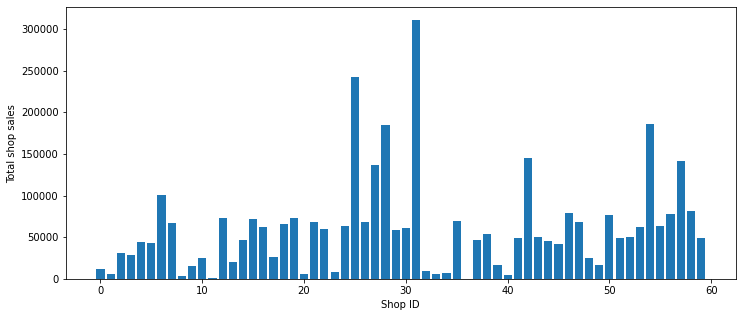

In [20]:
plt.figure(figsize=(12,5))
plt.bar(sales_per_shop.index, sales_per_shop['item_cnt_total'])
plt.xlabel("Shop ID")
plt.ylabel("Total shop sales")

#### Inspect outliers

Shop Nr. 36 appears to be non-existent. Let's verify that.

In [21]:
int(sales_per_shop.iloc[36]['item_cnt_total'])

330

#### Inspect overall average of sales per shop

In [22]:
int(sales_per_shop['item_cnt_total'].sum() / sales_per_shop.size)

60803

#### Conclusion

<div class="info">
    We verified that each and every shop has a positive sales record.
    <br>
    The average value of 60k sales per shop in total can be confirmed in the
    bar diagramm showing the distribution: there are about as many shop's with
    under-average performance as there are shops with an exceptionally
    high record.
    <br>
    The location of the shops might be of additional interest.
    <br>
    Shop Nr. 55 is the Online Store of the company.
    <br>
    Shop Nr. 20 to 32 are all located in the capital city of Moscow
</div>

### Inspect the time series

In [23]:
train_in_iso8601 = train.copy()
train_in_months = time_runtime(date_to_iso8601, train_in_iso8601)

Runtime: 13s


In [24]:
all_dates = set()

def put_all_days_in_set():
    for index, row in train_in_iso8601.iterrows():
        date = row['date']  # access the row
        date = datetime.strptime(date, '%Y-%m-%d')  # convert to datetime format
        date_as_int = date.toordinal()  # convert to ordinal format for date arithmetic
        all_dates.add((date_as_int, date))  # add to set

time_runtime(put_all_days_in_set)

Runtime: 1min & 48s


In [25]:
# transform the set to a list and sort it
all_dates = list(all_dates)
all_dates.sort()

In [26]:
counter_entries_in_all_dates = len(all_dates)
anomalies_in_date_series = set()

def check_for_interruptions():
    for i in range(counter_entries_in_all_dates):


        if i != (counter_entries_in_all_dates - 1):
            ordinal_this_date = all_dates[i][0]
            ordinal_successor_date = all_dates[i+1][0]

            if ordinal_this_date + 1 != ordinal_successor_date:
                print(f"{i}, {all_dates[i]}")
                anomalies_in_date_series.add(i)

time_runtime(check_for_interruptions)

739, (735608, datetime.datetime(2015, 1, 10, 0, 0))
768, (735639, datetime.datetime(2015, 2, 10, 0, 0))
794, (735667, datetime.datetime(2015, 3, 10, 0, 0))
823, (735698, datetime.datetime(2015, 4, 10, 0, 0))
851, (735728, datetime.datetime(2015, 5, 10, 0, 0))
880, (735759, datetime.datetime(2015, 6, 10, 0, 0))
908, (735789, datetime.datetime(2015, 7, 10, 0, 0))
937, (735820, datetime.datetime(2015, 8, 10, 0, 0))
966, (735851, datetime.datetime(2015, 9, 10, 0, 0))
994, (735881, datetime.datetime(2015, 10, 10, 0, 0))
1023, (735912, datetime.datetime(2015, 11, 10, 0, 0))
Runtime: 451ns


In [27]:
def check_if_interruption_is_weekend():
    for anomaly_index in anomalies_in_date_series:
        lower_bound = all_dates[anomaly_index]
        upper_bound = all_dates[anomaly_index + 1]

        lower_bound_formatted = lower_bound[1].strftime(iso8601_format)
        upper_bound_formatted = upper_bound[1].strftime(iso8601_format)
        prepare_print = f"{lower_bound_formatted} / {upper_bound_formatted}"

        # if it could be a weekend
        if upper_bound[0] - lower_bound[0] == 3:
            if lower_bound[1].weekday() == 4:
                prepare_print += f" is a weekend."

        print(prepare_print)

time_runtime(check_if_interruption_is_weekend)

2015-02-10 / 2015-02-13
2015-10-10 / 2015-10-13
2015-01-10 / 2015-01-13
2015-09-10 / 2015-09-13
2015-08-10 / 2015-08-13
2015-07-10 / 2015-07-13 is a weekend.
2015-06-10 / 2015-06-13
2015-05-10 / 2015-05-13
2015-04-10 / 2015-04-13 is a weekend.
2015-03-10 / 2015-03-13
2015-11-10 / 2015-12-01
Runtime: 199ns


<div class="info">
    Found a few breaks in the continuity of the timeseries.
    The breaks are mostly 2 days long.
    Identified the weekends which do not seem to have any particular
    significant impact.
    <br>
    The month of November, which has is to be predicted, has a few entries
    already present.
</div>

<div class="warn">
    Found an error in the series. The date of '2015-11-10' is not present
    in the dataset.
</div>